In [166]:
%autosave 50000

Autosaving every 50000 seconds


In [167]:
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns 
import pymc3 as pm 
import os 

font = {'family' : 'Arial',
        'weight' : 'normal',
        'size'   : 15}

plt.rc('font', **font)

In [168]:
from scipy import stats
from pymc3.distributions import draw_values
from pymc3.distributions import generate_samples
from pymc3.theanof import floatX
from pymc3.distributions.dist_math import bound
from pymc3.distributions import (Continuous, draw_values, generate_samples)

def assert_negative_support(var, label, distname, value=-1e-6):
    # Checks for evidence of positive support for a variable
    if var is None:
        return
    try:
        # Transformed distribution
        support = np.isfinite(var.transformed.distribution.dist
                              .logp(value).tag.test_value)
    except AttributeError:
        try:
            # Untransformed distribution
            support = np.isfinite(var.distribution.logp(value).tag.test_value)
        except AttributeError:
            # Otherwise no direct evidence of non-positive support
            support = False

    if np.any(support):
        msg = "The variable specified for {0} has negative support for {1}, ".format(
            label, distname)
        msg += "likely making it unsuitable for this parameter."
        warnings.warn(msg)

def get_tau_sigma(tau=None, sigma=None):
    if tau is None:
        if sigma is None:
            sigma = 1.
            tau = 1.
        else:
            tau = sigma**-2.
    else:
        if sigma is not None:
            raise ValueError("Can't pass both tau and sigma")
        else:
            sigma = tau**-.5
    tau = 1. * tau
    sigma = 1. * sigma
    return floatX(tau), floatX(sigma)

In [169]:
class weighted_Normal(pm.distributions.Continuous):

    def __init__(self, mu=0, sigma=None, tau=None, sd=None, weight =None,**kwargs):
        if sd is not None:
            sigma = sd
        tau, sigma = get_tau_sigma(tau=tau, sigma=sigma)
        self.sigma = self.sd = tt.as_tensor_variable(sigma)
        self.tau = tt.as_tensor_variable(tau)
        self.weight = tt.as_tensor_variable(weight)

        self.mean = self.median = self.mode = self.mu = mu = tt.as_tensor_variable(floatX(mu))
        self.variance = 1. / self.tau

        assert_negative_support(sigma, 'sigma', 'Normal')
        assert_negative_support(tau, 'tau', 'Normal')

        super().__init__(**kwargs)

    def random(self, point=None, size=None):
        
        mu, tau, _ = draw_values([self.mu, self.tau, self.sigma],
                                 point=point, size=size)
        return generate_samples(stats.norm.rvs, loc=mu, scale=tau**-0.5,
                                dist_shape=self.shape,
                                size=size)

    def logp(self, value):
        """
        Sum of Squares
        
        """
        sigma = self.sigma
        tau = self.tau
        mu = self.mu
        weight = self.weight
        
        logp = weight *  - tt.sqr(value - mu)/(2.0 * sigma * sigma)
        return logp.sum()


In [170]:
import pandas as pd
cwd = os.chdir('/Users/jackcarter/Missoula/Missoula Data/Missoula Data Final /Ephrata Fan')
dfx = pd.read_csv('g_b1_data_y.csv', engine = 'python')

In [171]:
dfx.head()

,Age,Age_Er,Ar40_,Ar40_Er,Ar39_,Ar39_Er,Pwr_Achieved,Dur_Heating_At_Req_Pwr,Run_Date,temp,temp_err,time,Da2,Da2_err
0,221.2000,4.547655,1.430845,0.004334,0.044170,0.000167,378,300,9/19/2019,377.491379,3.344715,297.601,1.030000e-06,5.420000e-20
1,247.6328,13.200720,0.341226,0.002397,0.012660,0.000076,391,300,9/19/2019,390.936207,3.092078,296.699,6.740000e-07,1.530000e-08
2,282.5425,14.984760,0.289030,0.002496,0.010972,0.000087,402,300,9/20/2019,402.493103,2.362044,296.613,7.210000e-07,1.330000e-08
3,317.9044,15.845450,0.279423,0.002489,0.010502,0.000087,411,300,9/20/2019,411.450000,2.086485,296.694,8.770000e-07,2.020000e-08
4,342.3768,13.294460,0.366157,0.002662,0.012012,0.000097,423,300,9/20/2019,423.043103,2.200966,296.617,1.170000e-06,2.810000e-08


In [172]:
# Age 
age = dfx['Age'].values
data = age
age_err = dfx['Age_Er'].values
age_m = age
N = age.shape[0]
age = data[data > 0]
ar39 = dfx['Ar39_'].values


In [173]:
# Part 1 ThermoCouple T Calibration 
## Step 1: Pyrometer Calibration
import os 
cwd = os.getcwd()
os.chdir("/Users/jackcarter/Desktop/Downloads")
df1 = pd.read_csv("PyroApril2018.csv")
c1 = df1.iloc[:,0:1]
c2 = df1.iloc[:,1:2]
x1 = c1.values
x2 = c2.values
x1 = x1[x1 >=0]
x2 = x2[x2 >=0]
ThermoT = x2
PyroT = x1
zpt = np.polyfit(x1,x2,3)

In [174]:
da2 = dfx['Da2'].values
da2_err = dfx['Da2_err'].values
temp1 = dfx['temp'].values
time = dfx['time'].values

temp = np.polyval(zpt, temp1)
tempk = temp + 273.15


In [175]:
sns.set_style('ticks')
font = {'family' : 'Arial',
        'weight' : 'normal',
        'size'   : 14}
plt.rc('font', **font)

In [176]:
def cumrel(x): 
    y = np.cumsum(x)
    z = y/y.max()
    return z

In [177]:
ar39 = cumrel(ar39)
age = age
age_err = age_err
data3 = ar39

In [178]:
# Plotting parameters

age_plot = np.insert(age,
                     0, age[0])
age_plot_err =  np.insert(age_err, 
                         0, age_err[0])
ar39_plot = np.insert(ar39,
                      0, 0)

In [179]:
tplot = 1e4/tempk
arr_err = da2_err/da2

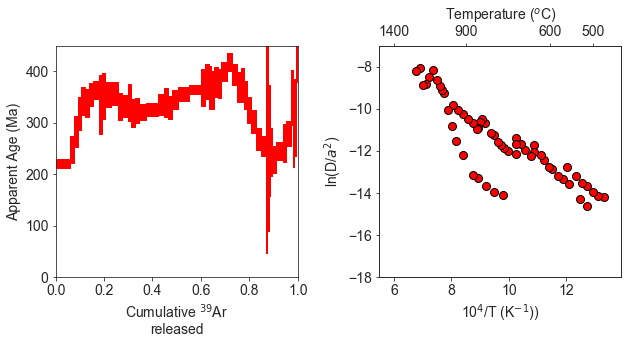

In [180]:
fig, ax = plt.subplots(1,2, figsize= (9,5))
ax[0].fill_between(ar39_plot, 
                age_plot + 2*age_plot_err, 
                age_plot - 2*age_plot_err, 
                color = 'red', 
                step = 'pre')

ax[0].set_ylim(0, 450)
ax[0].set_xlim(0,1)

ax[0].set_ylabel('Apparent Age (Ma)')
ax[0].set_xlabel('Cumulative $^{39}$Ar\nreleased');


ax[1].errorbar(tplot[1:N], np.log(da2[1:N]), yerr = arr_err[1:N],
              fmt = 'o', 
        markersize = 8, 
        markerfacecolor = 'red', 
        markeredgecolor = 'k')


ax2 = ax[1].twiny()

Tdc = np.array([500,  600, 900,  1400])
Tp = 10e3/(Tdc + 273.15)
labels = list(['500', '600', '900',   
              '1400'])
ax2.plot(tplot, np.log(da2), alpha = 0)
ax2.set_xlabel('Temperature ($^{o}$C)')
ax[1].set_xlim(Tp.min() - 0.5, Tp.max()+ 1)
ax2.set_xlim(Tp.min() - 0.5, Tp.max()+ 1)

ax2.set_xlabel('Temperature ($^{o}$C)')
ax2.set_xticks(Tp)
ax2.set_xticklabels(labels)

ax[1].set_xlabel('10$^{4}$/T (K$^{-1}$))')
ax[1].set_ylabel('ln(D/$a^{2}$)')
ax[1].set_ylim(-18, -7)
plt.tight_layout()


In [181]:
def inc_mdd(ea, d0, a,phi,temp, t):
    R = 8.314e-3
    D0t = ((phi/a)**2)* d0 * np.exp(-ea/(R*temp))*t
    q = (6./(np.pi**(3/2)))*np.sqrt((np.pi**2)*D0t)
    aa1 = np.sqrt(np.pi) * a**2 * R * temp**2
    bb1 = (phi/a)**2 * d0*np.exp(-ea/(R*temp))*t
    dd1 = 3 * d0 * ea * t * phi**2
    z1 = (dd1 * np.exp(-ea/(R*temp)))/(aa1 * np.sqrt(bb1))
    aa2 = a**2 * R *temp**2
    bb2 = (phi/a)**2 * d0*np.exp(-ea/(R*temp))*t
    cc1 = 3 * d0 * ea * t * phi**2 * np.exp(-ea/(R*temp))
    z2 = cc1/(np.sqrt(np.pi) * aa2 * np.sqrt(bb2)) - cc1/(aa2) 
    aa3 = a**2 * R * temp**2
    bb3 = (phi/a)**2 * d0*np.exp(-ea/(R*temp))*t
    cc2 = 6 * d0 * ea * t * phi**2
    z3 = (cc2 * np.exp(-(np.pi**2 * bb3) - (ea/(R*temp)))/(aa3))
    Q = tt.switch(q <= 0.9,
                z2,
                 z3)
    T = tt.switch(q < 0.1, 
                  z1,
                  Q)
    return T

In [182]:
data = age
arr_data = np.log(da2)
arr_data
tempk;
arr_err = da2_err/da2

In [183]:
from theano import shared
err_age = shared(age_err)
t_obs = dfx['time'].values
t_obs = t_obs
tempk = tempk
data = data
N = data.shape[0]
N

61

In [184]:
"""
Create Theano shared Variables
"""
age_err_data = shared(age_err[:N])
arr_err_data = shared((da2_err[:N] /da2[:N]))
age_data = shared(data)
arrh_data = shared(arr_data)

In [185]:
"""
Stick Breaking 
"""
import pymc3.distributions.transforms as tr
from theano import tensor as tt
def stick_break(beta): 
    pr = tt.concatenate([[1], 
                         tt.extra_ops.cumprod(1 - beta)[:-1]])
    return beta * pr


In [186]:
"""
Use simple linear model  to 
get testvals for a, Ea, D0
"""
"""
Use a simple linear Regression to 
get test values for Ea and D0
"""
from sklearn.linear_model import LinearRegression 
x_data = (10000/tempk).reshape(-1,1)
y_data = (np.log(da2)).reshape(-1,1)
model = LinearRegression()
model.fit(x_data[0:N-1],y_data[0:N-1])
intercept = model.intercept_
grad = model.coef_

Ea_test = grad *(-1/8.314e-3)
D0_test = np.exp(intercept)

Ea_test = Ea_test.reshape(1)
D0_test = D0_test.reshape(1)

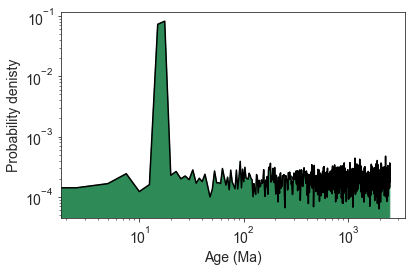

In [187]:
"""
Age Prior
"""
x1= np.random.uniform(0, 2500, 10000)
x2 = np.random.normal(16.3, 0.2, 10000)
age_prior = np.concatenate((x1, x2), axis = 0)

grid = np.linspace(0, 2500, 1000)
from scipy.stats import gaussian_kde
y = gaussian_kde(age_prior, 
                 bw_method = 0.001)
pdf_points = y.evaluate(grid)
plt.plot(grid, pdf_points, color = 'k')
plt.fill_between(grid, pdf_points, color = 'seagreen')
plt.xscale('log')
plt.yscale('log')

plt.xlabel('Age (Ma)')
plt.ylabel('Probability denisty')
plt.tight_layout()

In [199]:
"""
Truncate Number of 
Components and 
Domains
"""
k = 20
m = 10

"""
Start Model
"""
Q = pm.Model()
with Q: 
    "Components"
    alpha = pm.Gamma('alpha', 
                         1., 1.)

    beta = pm.Beta('beta', 1., alpha, 
                      shape = k)

    K_w = stick_break(beta)
    
    K = pm.Deterministic('K', 
                        K_w/K_w.sum(axis = 0,
                                    keepdims = True))
    
    C = pm.Categorical('C', 
                       p = K,
                       shape = (N,))
    
    """
    Domains
    """
    phi = pm.Dirichlet('phi', 
                      np.ones(m), 
                      shape = (k,m))
    
    D = pm.Categorical('D', 
                       p = phi[C], 
                       shape = N)

In [200]:
with Q: 
    """
    Diffusion Kinetics
    - Activation energy 
    - Frequency Factor
    """
    ea_mean = pm.Uniform('Ea_mean',
                      lower = 80, 
                      upper = 500, 
                      shape = k, 
                        testval = 90)
    
    ea_sd = pm.HalfNormal('ea_sd', 
                         sd = ea_mean/10, 
                         shape = k)
    
    ea = pm.Normal('Ea', mu = ea_mean, 
                  sd = ea_sd, 
                  shape = k)
    
    d0_mean = pm.Uniform('d0_mean',  
                      lower = 0.0, 
                      upper = 10000,
                      shape = k, 
                        testval = 0.00075)
    
    d0_sd = pm.HalfNormal('d0_sd', 
                         sd = d0_mean/10, 
                         shape = k)
    
    d0 = pm.Normal('d0', mu = d0_mean, 
                  sd  = d0_sd, 
                  shape = k)
    
    
    pm.Potential('diff_kin_con', 
                tt.switch(ea < 80, 
                         -np.inf, 0)+ 
                tt.switch(ea > 500, 
                         -np.inf, 0) + 
                tt.switch(d0 < 0, 
                         -np.inf, 0) + 
                tt.switch(d0 > 10000, 
                         -np.inf, 0))

In [201]:
import pymc3.distributions.transforms as tr
with Q: 
    """
    MDD grain size or domain size 
    """
    a = pm.Uniform('a', lower = 0.00001, 
                  upper = 0.0032, 
                  shape = (k,m), 
                  testval = 0.003)

In [202]:
with Q: 
    """
    Age Prior
    """
    age_mean = pm.Interpolated('age_mean',
                              grid,
                              pdf_points,
                              shape = k, 
                         testval = data.mean())
    
    age_sd = pm.HalfNormal('age_sd', 
                          sd = age_mean/10,
                          shape = k)
    
    age_model = pm.Normal('age_model', mu = age_mean, 
                         sd = age_sd, 
                         shape = k)
    
    pm.Potential('age_con', 
                tt.switch(age_model < 0, 
                         -np.inf, 0) + 
                tt.switch(age_model > 2500, 
                         -np.inf, 0))
    
    

In [203]:
with Q: 
    """
    Indexing everything 
    for the trace
    """   
    age_comp = pm.Deterministic('age_comp',
                                age_model[C])
    ea_comp = pm.Deterministic('ea_comp',
                               ea[C])
    d0_comp = pm.Deterministic('d0_comp',
                               d0[C])
    phi_comp = pm.Deterministic('phi_comp',
                                K[C])
    a_domain = pm.Deterministic("a_domain",
                                a[C,D])
    phi_domain = pm.Deterministic('phi_domain',
                                  phi[C,D])

In [204]:
with Q:
    """
    Age Spectra Model
    """
    Z2 = K[C] * inc_mdd(ea[C], 
                d0[C], 
                a[C,D], 
                phi[C,D],
                tempk[:,None],
                t_obs[:,None])
    
    Y_sum2 = Z2.sum(axis = 1)
    
    XX = (Z2 * age_model[C]).sum(axis = 1)

    mu2 = (XX/Y_sum2)

In [205]:
with Q: 
    """
    Incremental Release Trace
    """
    inc_rel = pm.Deterministic('inc_rel', Y_sum2)

In [206]:
with Q:
    """
    Arrhenius Model
    """
    R = 8.314e-3
    
    yy2 = ((phi[C,D]/a[C,D])**2) \
                 * (d0[C] * np.exp(-ea[C]/(R*tempk)))
    
    y2 = K[C] * yy2
    mu1 = tt.log(y2)

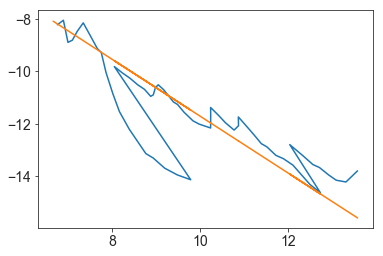

In [207]:
plt.plot(tplot, np.log(da2))
plt.plot(tplot, mu1.tag.test_value)

In [208]:
"""
Calculate Model weights
"""
def logp_w(data, model, err): 
    y =  - ((data - model)**2)/(2*err * err)
    return y.sum()

with Q: 

    y1 = logp_w(data, 
                mu2.tag.test_value,
                age_err)
    y2 = logp_w(arr_data[1:N-1],
                mu1.tag.test_value[1:N-1],
                arr_err[1:N-1])
    
    weight = y1/y2


In [209]:
weight

1.1645446543310235e-05

In [210]:
with Q: 
    obs1 = weighted_Normal('obs1', mu = mu2, 
                           sd = age_err_data, 
                           observed = age_data, 
                          weight = 1)

In [211]:
with Q: 
    obs2 = weighted_Normal('obs2', mu1[1:N-1],
                     arr_err_data[1:N-1], 
                     observed = arrh_data[1:N-1], 
                           weight = weight)

In [212]:
Q.check_test_point()

alpha_log__              -1.00
beta_logodds__          -27.73
C                       -42.28
phi_stickbreaking__    -204.48
D                      -140.46
Ea_mean_interval__      -75.24
ea_sd_log__             -15.40
Ea                      -57.81
d0_mean_interval__     -328.12
d0_sd_log__             -15.40
d0                      176.10
a_interval__           -566.84
age_mean_interval__     -70.49
age_sd_log__            -15.40
age_model               -90.67
obs1                  -4977.07
obs2                  -4977.07
Name: Log-probability of test_point, dtype: float64

In [247]:
SAMPLES = 20000
BURN = 50000
SEED = np.random.seed(123)

with Q:
    step1 = pm.CategoricalGibbsMetropolis([C,D]) 
    
    
    step2 = pm.Metropolis([d0, d0_sd, d0_mean,
                           ea, ea_mean, ea_sd,
                           a, phi,
                           age_mean,
                           age_sd,
                           age_model], 
                         scaling = 1000)
    
    step3 = pm.Metropolis([alpha,
                           beta])
        
    trace = pm.sample(SAMPLES,
                     tune = BURN, 
                     step = [step1,
                             step2, 
                             step3],
                     random_seed = SEED, 
                     chains = 4, 
                     njobs = 4)

Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>CategoricalGibbsMetropolis: [D, C]
>CompoundStep
>>Metropolis: [age_model]
>>Metropolis: [age_sd]
>>Metropolis: [age_mean]
>>Metropolis: [phi]
>>Metropolis: [a]
>>Metropolis: [ea_sd]
>>Metropolis: [Ea_mean]
>>Metropolis: [Ea]
>>Metropolis: [d0_mean]
>>Metropolis: [d0_sd]
>>Metropolis: [d0]
>CompoundStep
>>Metropolis: [beta]
>>Metropolis: [alpha]
Sampling 4 chains: 100%|██████████| 280000/280000 [3:58:23<00:00,  7.81draws/s]  
The gelman-rubin statistic is larger than 1.4 for some parameters. The sampler did not converge.
The estimated number of effective samples is smaller than 200 for some parameters.


Text(0, 0.5, 'Log probability')

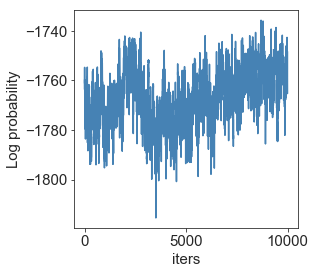

In [248]:
SAMPLES = 10000
logp_model = Q.logp
# Every Hundreth accepted sample
logp = [logp_model(i) for i in trace[-SAMPLES:]]
logp_x = np.array([logp])
logp_x = logp_x.reshape(SAMPLES)



plt.figure(figsize = (4,4))
plt.plot(logp_x,
        color = 'steelblue')
plt.xlabel('iters')
plt.ylabel('Log probability')

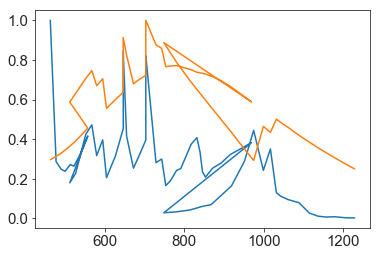

In [249]:
ar39 = dfx['Ar39_'].values
plt.plot(temp[:N],
         ar39[:N]/ar39[:N].max())
plt.plot(temp[:N], 
         trace['inc_rel'].mean(axis = 0)/trace['inc_rel'].mean(axis = 0).max())

In [266]:
SAMPLES = 20000

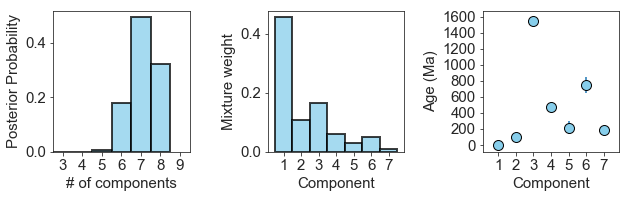

In [272]:
font = {'family' : 'Arial',
        'weight' : 'normal',
        'size'   : 15}

plt.rc('font', **font)

fig, ax = plt.subplots(1, 3, figsize = (9, 3))
n_comp = np.apply_along_axis(lambda x: np.unique(x).size, 
                            1, trace['C'][-SAMPLES::10])

n_comp =  n_comp
ncmp = n_comp.mean(axis = 0).astype(int) + 1
bins = np.arange(n_comp.min() - 1, n_comp.max() + 1)

ax[0].hist(n_comp +1,
        bins=bins,
        density=True,
        lw= 2,
        alpha=0.75, 
       edgecolor = 'k', 
        facecolor = 'skyblue');

ax[0].set_xticks(bins + 0.5);
ax[0].set_xticklabels(bins);
ax[0].set_xlim(bins.min(),bins.max() + 1);
ax[0].set_xlabel('# of components');



plot_w = np.arange(ncmp) + 1

ax[1].bar(plot_w - 0, trace['K'][-SAMPLES::10].mean(axis=0)[:ncmp],
          width=1., lw=2, 
      edgecolor = 'k', alpha = 0.75, 
         facecolor = 'skyblue');

ax[1].set_xlabel('Component');

ax[1].set_ylabel('Mixture weight');

ax[1].locator_params(axis='x', nbins=12)
#ax[1].set_xlim(0.1, ncmp + 0.9)

ax[2].errorbar(np.linspace(1, ncmp,ncmp),
             trace['age_model'][-SAMPLES::10].mean(axis = 0)[:ncmp], 
             yerr = 2*trace['age_model'][-SAMPLES::10].std(axis = 0)[:ncmp], 
             fmt ='o', 
             markersize = 10, 
             markeredgecolor = 'k', 
             markerfacecolor = 'skyblue')

ax[2].set_xlabel('Component');

ax[2].set_ylabel('Age (Ma)');
ax[0].set_ylabel('Posterior Probability')

ax[2].locator_params(axis='x', nbins=ncmp + 1)
ax[2].locator_params(axis='y', nbins=12)
ax[2].set_xlim(0.1, ncmp  +0.9)
ax[1].set_xlim(0.1, ncmp  +0.9)
ax[1].locator_params(axis='x', nbins=ncmp + 1)
plt.tight_layout()
plt.savefig('/Users/jackcarter/Missoula/Missoula outputs/ef_gb1_ncmp.pdf')


In [268]:
np.set_printoptions(suppress=True)
print(trace['age_model'][-SAMPLES::10].mean(axis = 0).round(2))


[   5.31   94.92 1549.65  475.48  218.43  751.18  182.98  342.57  771.17
  503.24  253.45  228.74  621.03  373.42  748.42  700.    514.19  479.14
  437.91  366.8 ]


In [269]:
trace['age_model'][-SAMPLES::10].std(axis = 0).round(2)

array([ 4.97, 14.2 , 23.51, 17.01, 38.43, 48.04, 24.74, 33.79, 30.17,
       27.64, 25.32, 27.74, 55.8 , 32.71, 76.92, 27.43, 20.03, 30.66,
       24.13, 30.28])

In [254]:
trace['Ea'][-SAMPLES::10].mean(axis = 0).round(2)

array([ 81.47,  99.66,  95.88, 105.84,  88.97, 106.51,  87.15,  94.55,
       103.92,  85.88,  90.1 ,  99.51,  82.23,  95.03,  86.28,  91.45,
        93.57,  89.36,  96.72,  88.96])

In [255]:
from scipy import stats
with Q: 
    ppc = pm.sample_ppc(trace,
                        5000)

/Applications/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:4: DeprecationWarning: sample_ppc() is deprecated.  Please use sample_posterior_predictive()
  after removing the cwd from sys.path.
100%|██████████| 5000/5000 [07:50<00:00,  4.10it/s] 


In [256]:
# Mean Predictive Models
Z2 = ppc['obs1'].mean(axis = 0)
low2, high2 = np.percentile(ppc['obs1'], 
                            [50 - 34, 50 + 34], 
                            axis = 0)

# Frel_model
inc_model = trace['inc_rel'].mean(axis = 0)
frel_model = cumrel(inc_model)

In [257]:
sns.set_style('ticks')
font = {'family' : 'Arial',
        'weight' : 'normal',
        'size'   : 16}

plt.rc('font', **font)

# Plotting parameters 
ar39 = cumrel(ar39[:37])

low2_plot = np.insert(low2, 0, low2[0])
high2_plot = np.insert(high2, 0, high2[0])
z2_plot = np.insert(Z2, 0, Z2[0])
frel_model_plot = np.insert(frel_model, 0, 0)

data2_plot = np.insert(ar39, 0, 0)
data_plot = np.insert(data, 0, data[0])
age_err_plot = np.insert(age_err, 0, age_err[0])


Text(0, 0.5, 'Cumulative density')

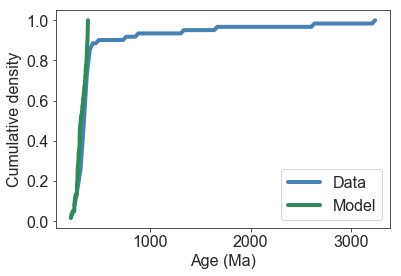

In [258]:
num_bins = 100 
counts, bin_edges = np.histogram(age, bins = num_bins, 
                                density = True)
cdf = np.cumsum(counts)

counts2, bin_edges2 = np.histogram(Z2, bins = num_bins, 
                                density = True)
cdf2 = np.cumsum(counts2)

plt.plot(bin_edges[1:], cdf/cdf[-1], 
        label = 'Data', 
        lw = 4, 
        color  = 'steelblue')
plt.plot(bin_edges2[1:], cdf2/cdf2[-1], 
        label = 'Model', 
        lw = 4, 
        color= 'seagreen')

plt.legend()
plt.xlabel('Age (Ma)')
plt.ylabel('Cumulative density')

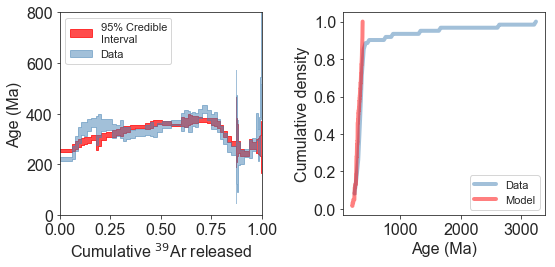

In [259]:
fig,ax = plt.subplots(1, 2, figsize = (8, 4))

ax[0].fill_between(ar39_plot, low2_plot, 
                 high2_plot, 
                 alpha = 0.7, 
                color = 'r', 
                label = '95% Credible\nInterval', 
                step = 'pre')

ax[0].fill_between(ar39_plot, 
                age_plot + 2*age_plot_err, 
                age_plot - 2*age_plot_err, 
                color = 'steelblue', 
                step = 'pre', 
                label = 'Data',
                alpha = 0.5)


ax[1].plot(bin_edges[1:], cdf/cdf[-1], 
        label = 'Data', 
        lw = 4, 
        color  = 'steelblue', 
          alpha = 0.5)
ax[1].plot(bin_edges2[1:], cdf2/cdf2[-1], 
        label = 'Model', 
        lw = 4, 
        color= 'r', 
          alpha = 0.5)


ax[0].set_xlabel('Cumulative $^{39}$Ar released')
ax[0].set_ylabel('Age (Ma)')
ax[0].legend(loc = 2, fontsize = 11)
ax[0].set_xlim(0, 1)
ax[0].set_ylim(0, 800)

ax[1].legend(loc = 4, fontsize = 11)
ax[1].set_xlabel('Age (Ma)')
ax[1].set_ylabel('Cumulative density')
plt.tight_layout()


In [260]:
def arr_plot(ea, d0, a, temp): 
    R = 8.314e-3
    da2 = (d0/a.max()**2) * np.exp(-ea/(R*temp))
    
    return np.log(da2)

In [261]:
tplot = 10000/tempk

# Mean Predictive Models
Z1 = ppc['obs2'].mean(axis = 0)
low1, high1 = np.percentile(ppc['obs2'], [50 - 34, 50 + 34], axis = 0)

(-20, -5)

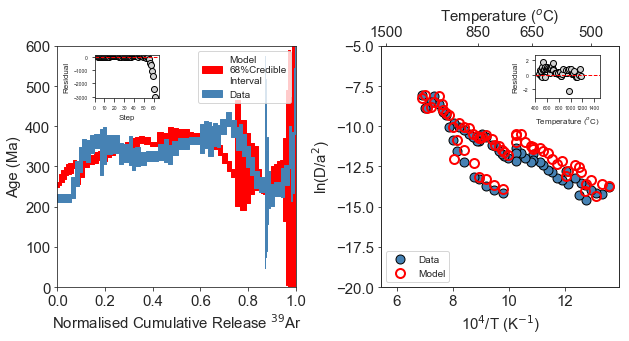

In [262]:
sns.set_style('ticks')

font= {"family": "Arial", 
      "weight": "normal",
      "size":15}

plt.rc("font", **font)


fig, ax = plt.subplots(1,2, figsize = (9, 5))

ax[0].fill_between(frel_model_plot, low2_plot, 
                 high2_plot, 
                 alpha = 1, 
                color = 'r', 
                label = 'Model\n68%Credible\nInterval', 
                  step = 'pre', 
                  interpolate = True,  
                  lw = 1)


ax[0].fill_between(ar39_plot, 
                age_plot + 2*age_plot_err, 
                age_plot - 2*age_plot_err, 
                color = 'steelblue', 
                step = 'pre', 
                label = 'Data')

ax[0].set_xlabel('Normalised Cumulative Release $^{39}$Ar')
ax[0].set_ylabel('Age (Ma)')




ax[1].plot(tplot[0:N-2], arr_data[0:N-2], 
          'o', markerfacecolor = 'steelblue', 
          markeredgecolor = 'k', 
          markersize = 9, label = 'Data')


ax[1].plot(tplot[0:N-2],Z1, 'or',
             markerfacecolor = 'None',
            alpha = 1, 
             markeredgecolor = 'r', markeredgewidth = 2, 
            markersize = 9, 
            label = 'Model')


#### Temp #####

ax2 = ax[1].twiny()

Tdc = np.array([500,  650, 850,  1500])
Tp = 10e3/(Tdc + 273.15)
labels = list(['500', '650', '850',   
              '1500'])
ax2.plot(tplot[0:N-2], arr_data[0:N-2], alpha = 0)
ax2.set_xlabel('Temperature ($^{o}$C)')
ax[1].set_xlim(Tp.min() - 0.2, Tp.max()+ 1)
ax2.set_xlim(Tp.min() -0.2, Tp.max()+ 1)

ax2.set_xlabel('Temperature ($^{o}$C)')
ax2.set_xticks(Tp)
ax2.set_xticklabels(labels)


ax3 =plt.axes([0.84,0.7,0.1,0.12])

ax3.plot(tempk[0:N-2] - 273.15, Z1 - arr_data[0:N-2], 'ok', 
        markeredgecolor = 'k', 
        markerfacecolor = 'lightgrey')
qqq = Z1 - arr_data[0:N-2]
ax3.axhline(0, lw = 1, ls = '--', 
           color = 'r')
ax3.set_ylabel('Residual', fontsize = 8)
ax3.set_xlabel('Temperature ($^{o}$C)', fontsize = 8)
ax3.set_ylim(qqq.min() - 1, qqq.max() + 1)
ax3.tick_params(labelsize = 5)
ax3.locator_params(axis='x', nbins=6)
ax3.set_xlim(400, 1500)

ax[1].set_xlabel('10$^{4}$/T (K$^{-1}$)')
ax[1].set_ylabel('ln(D/a$^{2}$)')
ax[1].locator_params(axis='y', nbins=6)
ax[1].locator_params(axis='x', nbins=6)


ax4 =plt.axes([0.16,0.7,0.1,0.12])

ax4.plot(np.linspace(1, N, N).astype(int), Z2 - data, 'ok', 
        markeredgecolor = 'k', 
        markerfacecolor = 'lightgrey')
qqq2 = Z2 - data
ax4.set_ylim(qqq2.min() - 50, qqq2.max() + 50)

ax4.axhline(0, lw = 1, ls = '--', 
           color = 'r')
ax4.set_ylabel('Residual', fontsize = 8)
ax4.set_xlabel('Step', fontsize = 8)
ax4.tick_params(labelsize = 5)
ax4.locator_params(axis='x', nbins=10)
ax4.set_xlim(0, N+5)
ax[0].set_ylim(0, 600)
ax[0].set_xlim(0, 1)

ax[0].legend(loc = 1, fontsize = 10)
ax[1].legend(loc = 3, fontsize = 10)

plt.tight_layout()
ax[1].set_ylim(-20, -5)


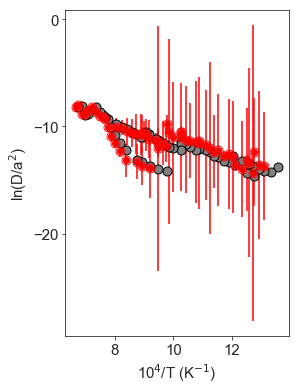

In [263]:
fig = plt.figure(figsize = (4,6))
low1, high1 = np.percentile(ppc['obs2'], [2.5, 97.5], axis = 0)
plt.plot(tplot, arr_data, 
          'o', markerfacecolor = 'grey', 
          markeredgecolor = 'k', 
          markersize = 9, label = 'Data')


plt.plot(tplot[-len(Z1):],Z1[-len(Z1):], 'or',
             markerfacecolor = 'None',
            alpha = 1, 
             markeredgecolor = 'r', markeredgewidth = 0.9, 
            markersize = 9, 
            label = 'Model')

plt.errorbar(tplot[-len(Z1):], Z1[-len(Z1):], 
           yerr = 2*(high1[-len(Z1):] - low1[-len(Z1):]),
           color = 'r', 
            fmt = 'o')

plt.xlabel('10$^{4}$/T (K$^{-1}$)')
plt.ylabel('ln(D/a$^{2}$)')
plt.locator_params(axis='y', nbins=6)
plt.locator_params(axis='x', nbins=6)


In [270]:
SAMPLES = 20000

In [271]:
df_age = pd.DataFrame({"age_model":Z2,
                      "age_model_low":low2, 
                      "age_model_high": high2,
                      "frel_model": frel_model})

df_arr = pd.DataFrame({"arr_model": Z1, 
                      "arr_model_low": low1,
                      "arr_model_high": high1})

df_age_comp = pd.DataFrame({"age1": trace['age_model'][-SAMPLES::10][:,0],
                      "age2": trace['age_model'][-SAMPLES::10][:,1],
                      "age3": trace['age_model'][-SAMPLES::10][:,2],
                      "age4": trace['age_model'][-SAMPLES::10][:,3],
                      "age5": trace['age_model'][-SAMPLES::10][:,4],
                      "age6": trace['age_model'][-SAMPLES::10][:,5],
                      "age7": trace['age_model'][-SAMPLES::10][:,6]})


df_w_comp = pd.DataFrame({"w1": trace['K'][-SAMPLES::10][:,0],
                      "w2": trace['K'][-SAMPLES::10][:,1],
                      "w3": trace['K'][-SAMPLES::10][:,2],
                      "w4": trace['K'][-SAMPLES::10][:,3],
                      "w5": trace['K'][-SAMPLES::10][:,4],
                      "w6": trace['K'][-SAMPLES::10][:,5],
                      "w7": trace['K'][-SAMPLES::10][:,6]})




In [273]:
df_age.to_csv("/Users/jackcarter/Missoula/Missoula outputs/ef_gb1_age.csv")
df_arr.to_csv("/Users/jackcarter/Missoula/Missoula outputs/ef_gb1_arr.csv")
df_age_comp.to_csv("/Users/jackcarter/Missoula/Missoula outputs/ef_gb1_age_comp.csv")
df_w_comp.to_csv("/Users/jackcarter/Missoula/Missoula outputs/ef_gb1_w_comp.csv")